In [1]:
import torch

DEVICE = torch.device( 'cuda:0' if torch.cuda.is_available() else 'cpu')
MODEL_TYPE = 'vit_h'

import os
HOME = os.getcwd()
print("HOME:", HOME)

import os

CHECKPOINT_PATH = os.path.join(HOME, "weights", "sam_vit_h_4b8939.pth")
print(CHECKPOINT_PATH, "; exist:", os.path.isfile(CHECKPOINT_PATH))

HOME: /Users/anshmadan/Coding/IML Final Project
/Users/anshmadan/Coding/IML Final Project/weights/sam_vit_h_4b8939.pth ; exist: True


In [2]:
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH).to(device=DEVICE)

In [3]:
mask_generator = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=32,
    pred_iou_thresh=0.85,  # Slightly lower to get more masks
    stability_score_thresh=0.90,  # Slightly lower to allow more masks
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=100
)

In [4]:
import os

IMAGE_NAME = "images.jpeg"
IMAGE_PATH = os.path.join(HOME, "segmentation", IMAGE_NAME)


In [5]:
import cv2
import supervision as sv

image_bgr = cv2.imread(IMAGE_PATH)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

sam_result = mask_generator.generate(image_rgb)
print(f"Number of masks generated by SAM: {len(sam_result)}")


Number of masks generated by SAM: 121


In [6]:
masks_and_areas = []
for mask in sam_result:
    segmentation = mask['segmentation'].astype(np.uint8)
    contours, _ = cv2.findContours(segmentation, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if len(contours) > 0:
        contour = max(contours, key=cv2.contourArea)
        area = cv2.contourArea(contour)
        # Store mask and area for later sorting
        masks_and_areas.append((segmentation, area))

# Sort masks by area (descending)
masks_and_areas.sort(key=lambda x: x[1], reverse=True)

# Let's pick the top masks (e.g., top 3) and see what bounding boxes we get
top_masks = masks_and_areas[:3]

NameError: name 'np' is not defined

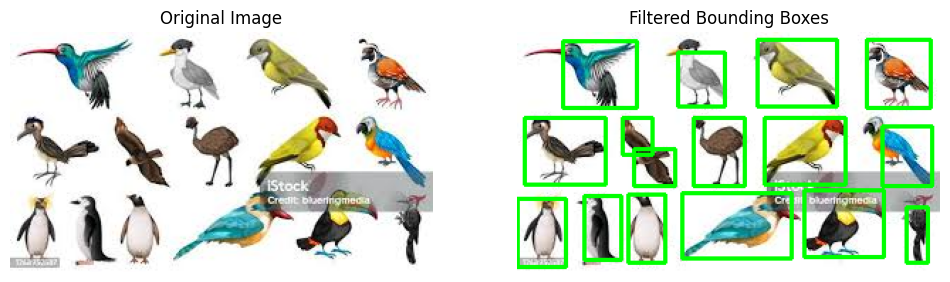

In [8]:
import numpy as np
import cv2

# Define multiple color ranges for different bird colors
bird_color_ranges = [
    # Dark birds (gray/black)
    (np.array([0, 0, 0]), np.array([180, 50, 180])),
    # Brown/red birds
    (np.array([0, 30, 30]), np.array([25, 255, 255])),
    # Yellow/bright birds
    (np.array([15, 50, 50]), np.array([40, 255, 255])),
    # White birds
    (np.array([0, 0, 180]), np.array([180, 50, 255])),
    # Blue birds
    (np.array([90, 50, 50]), np.array([130, 255, 255]))
]

def create_color_mask(image_hsv, ranges):
    final_mask = np.zeros(image_hsv.shape[:2], dtype=np.uint8)
    for lower, upper in ranges:
        mask = cv2.inRange(image_hsv, lower, upper)
        final_mask = cv2.bitwise_or(final_mask, mask)
    return final_mask

# Convert image to HSV
image_hsv = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2HSV)

# Create combined color mask for birds
color_mask = create_color_mask(image_hsv, bird_color_ranges)

# Apply morphological operations to clean up the mask
kernel = np.ones((3,3), np.uint8)
color_mask = cv2.morphologyEx(color_mask, cv2.MORPH_OPEN, kernel)
color_mask = cv2.morphologyEx(color_mask, cv2.MORPH_CLOSE, kernel)

# Filter masks based on color and shape characteristics
filtered_masks = []
for mask in sam_result:
    segmentation = mask['segmentation'].astype(np.uint8)
    
    # Calculate overlap with color mask
    overlap = cv2.bitwise_and(segmentation, color_mask)
    overlap_ratio = np.sum(overlap) / np.sum(segmentation)
    
    # Calculate contour properties
    contours, _ = cv2.findContours(segmentation, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if len(contours) > 0:
        contour = max(contours, key=cv2.contourArea)
        area = cv2.contourArea(contour)
        perimeter = cv2.arcLength(contour, True)
        
        # Calculate shape features
        circularity = 4 * np.pi * area / (perimeter * perimeter) if perimeter > 0 else 0
        
        # Bird-specific filtering criteria
        if (overlap_ratio > 0.2 and  # More lenient color match
            200 < area < 25000 and   # Wider size range
            0.1 < circularity < 0.9): # More lenient shape criteria
            filtered_masks.append(segmentation)

# Generate bounding boxes with improved filtering
bounding_boxes = []
for mask in filtered_masks:
    binary_mask = (mask > 0).astype(np.uint8)
    coords = np.where(binary_mask == 1)
    if len(coords[0]) > 0 and len(coords[1]) > 0:
        y_coords, x_coords = coords
        x_min, x_max = x_coords.min(), x_coords.max()
        y_min, y_max = y_coords.min(), y_coords.max()
        
        # Calculate aspect ratio and density
        width = x_max - x_min + 1
        height = y_max - y_min + 1
        aspect_ratio = height / width
        area = width * height
        density = np.sum(binary_mask[y_min:y_max+1, x_min:x_max+1]) / area
        
        # More precise bird-specific filtering
        if (0.3 < aspect_ratio < 3.0 and    # More flexible aspect ratios
            density > 0.15 and              # More lenient density threshold
            200 < area < 25000):            # Wider size range for birds
            bounding_boxes.append((x_min, y_min, x_max, y_max))

# Apply Non-Maximum Suppression with adjusted overlap threshold
def non_max_suppression(boxes, overlap_thresh=0.2):  # Lower threshold for better separation
    if len(boxes) == 0:
        return []
    boxes = np.array(boxes)
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]
    areas = (x2 - x1 + 1) * (y2 - y1 + 1)
    indices = np.argsort(y2)
    picked = []
    
    while len(indices) > 0:
        last = len(indices) - 1
        i = indices[last]
        picked.append(i)
        
        xx1 = np.maximum(x1[i], x1[indices[:last]])
        yy1 = np.maximum(y1[i], y1[indices[:last]])
        xx2 = np.minimum(x2[i], x2[indices[:last]])
        yy2 = np.minimum(y2[i], y2[indices[:last]])
        
        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)
        overlap = (w * h) / areas[indices[:last]]
        
        indices = np.delete(indices, np.concatenate(([last], np.where(overlap > overlap_thresh)[0])))
    
    return boxes[picked].tolist()

# Filter bounding boxes using NMS
final_boxes = non_max_suppression(bounding_boxes)

# Draw bounding boxes on the original image
output_image = image_bgr.copy()
for (x_min, y_min, x_max, y_max) in final_boxes:
    cv2.rectangle(output_image, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)

# Visualize the results
images = [image_bgr, output_image]
titles = ["Original Image", "Filtered Bounding Boxes"]
sv.plot_images_grid(
    images=images,
    grid_size=(1, 2),
    titles=titles
)

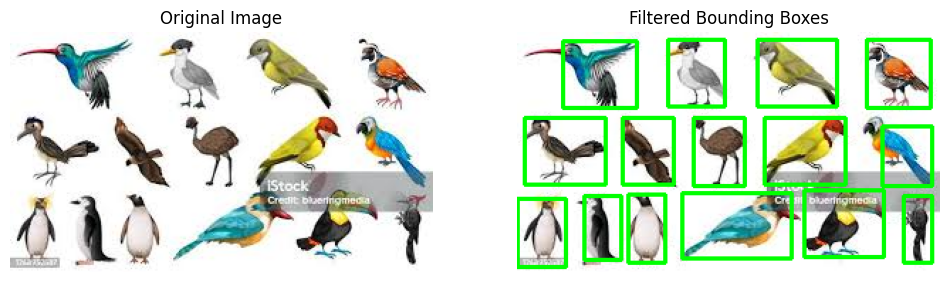

In [9]:
import numpy as np
import cv2

# Define multiple color ranges for different bird colors
bird_color_ranges = [
    # Dark birds (gray/black)
    (np.array([0, 0, 0]), np.array([180, 50, 180])),
    # Brown/red birds
    (np.array([0, 30, 30]), np.array([25, 255, 255])),
    # Yellow/bright birds
    (np.array([15, 50, 50]), np.array([40, 255, 255])),
    # White birds
    (np.array([0, 0, 180]), np.array([180, 50, 255])),
    # Blue birds
    (np.array([90, 50, 50]), np.array([130, 255, 255]))
]

def create_color_mask(image_hsv, ranges):
    final_mask = np.zeros(image_hsv.shape[:2], dtype=np.uint8)
    for lower, upper in ranges:
        mask = cv2.inRange(image_hsv, lower, upper)
        final_mask = cv2.bitwise_or(final_mask, mask)
    return final_mask

# Convert image to HSV
image_hsv = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2HSV)

# Create combined color mask for birds
color_mask = create_color_mask(image_hsv, bird_color_ranges)

# Apply morphological operations to clean up the mask
kernel = np.ones((3,3), np.uint8)
color_mask = cv2.morphologyEx(color_mask, cv2.MORPH_OPEN, kernel)
color_mask = cv2.morphologyEx(color_mask, cv2.MORPH_CLOSE, kernel)

# Filter masks based on color and shape characteristics
filtered_masks = []
for mask in sam_result:
    segmentation = mask['segmentation'].astype(np.uint8)
    
    # Calculate overlap with color mask
    overlap = cv2.bitwise_and(segmentation, color_mask)
    overlap_ratio = np.sum(overlap) / np.sum(segmentation)
    
    # Calculate contour properties
    contours, _ = cv2.findContours(segmentation, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if len(contours) > 0:
        contour = max(contours, key=cv2.contourArea)
        area = cv2.contourArea(contour)
        perimeter = cv2.arcLength(contour, True)
        
        # Calculate shape features
        circularity = 4 * np.pi * area / (perimeter * perimeter) if perimeter > 0 else 0
        
        # Bird-specific filtering criteria
        if (overlap_ratio > 0.2 and  # More lenient color match
            200 < area < 25000 and   # Wider size range
            0.1 < circularity < 0.9): # More lenient shape criteria
            filtered_masks.append(segmentation)

# Generate bounding boxes with improved filtering
bounding_boxes = []
for mask in filtered_masks:
    binary_mask = (mask > 0).astype(np.uint8)
    coords = np.where(binary_mask == 1)
    if len(coords[0]) > 0 and len(coords[1]) > 0:
        y_coords, x_coords = coords
        x_min, x_max = x_coords.min(), x_coords.max()
        y_min, y_max = y_coords.min(), y_coords.max()
        
        # Calculate aspect ratio and density
        width = x_max - x_min + 1
        height = y_max - y_min + 1
        aspect_ratio = height / width
        area = width * height
        density = np.sum(binary_mask[y_min:y_max+1, x_min:x_max+1]) / area
        
        # More precise bird-specific filtering
        if (0.3 < aspect_ratio < 3.0 and    # More flexible aspect ratios
            density > 0.15 and              # More lenient density threshold
            1000 < area < 25000):            # Wider size range for birds
            bounding_boxes.append((x_min, y_min, x_max, y_max))

# Apply Non-Maximum Suppression with adjusted overlap threshold
def non_max_suppression(boxes, overlap_thresh=0.2):  # Lower threshold for better separation
    if len(boxes) == 0:
        return []
    boxes = np.array(boxes)
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]
    areas = (x2 - x1 + 1) * (y2 - y1 + 1)
    indices = np.argsort(y2)
    picked = []
    
    while len(indices) > 0:
        last = len(indices) - 1
        i = indices[last]
        picked.append(i)
        
        xx1 = np.maximum(x1[i], x1[indices[:last]])
        yy1 = np.maximum(y1[i], y1[indices[:last]])
        xx2 = np.minimum(x2[i], x2[indices[:last]])
        yy2 = np.minimum(y2[i], y2[indices[:last]])
        
        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)
        overlap = (w * h) / areas[indices[:last]]
        
        indices = np.delete(indices, np.concatenate(([last], np.where(overlap > overlap_thresh)[0])))
    
    return boxes[picked].tolist()

# Filter bounding boxes using NMS
final_boxes = non_max_suppression(bounding_boxes)

# Draw bounding boxes on the original image
output_image = image_bgr.copy()
for (x_min, y_min, x_max, y_max) in final_boxes:
    cv2.rectangle(output_image, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)

# Visualize the results
images = [image_bgr, output_image]
titles = ["Original Image", "Filtered Bounding Boxes"]
sv.plot_images_grid(
    images=images,
    grid_size=(1, 2),
    titles=titles
)

In [10]:
print(sam_result[0].keys())

dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


In [10]:
print(len(sam_result))

121


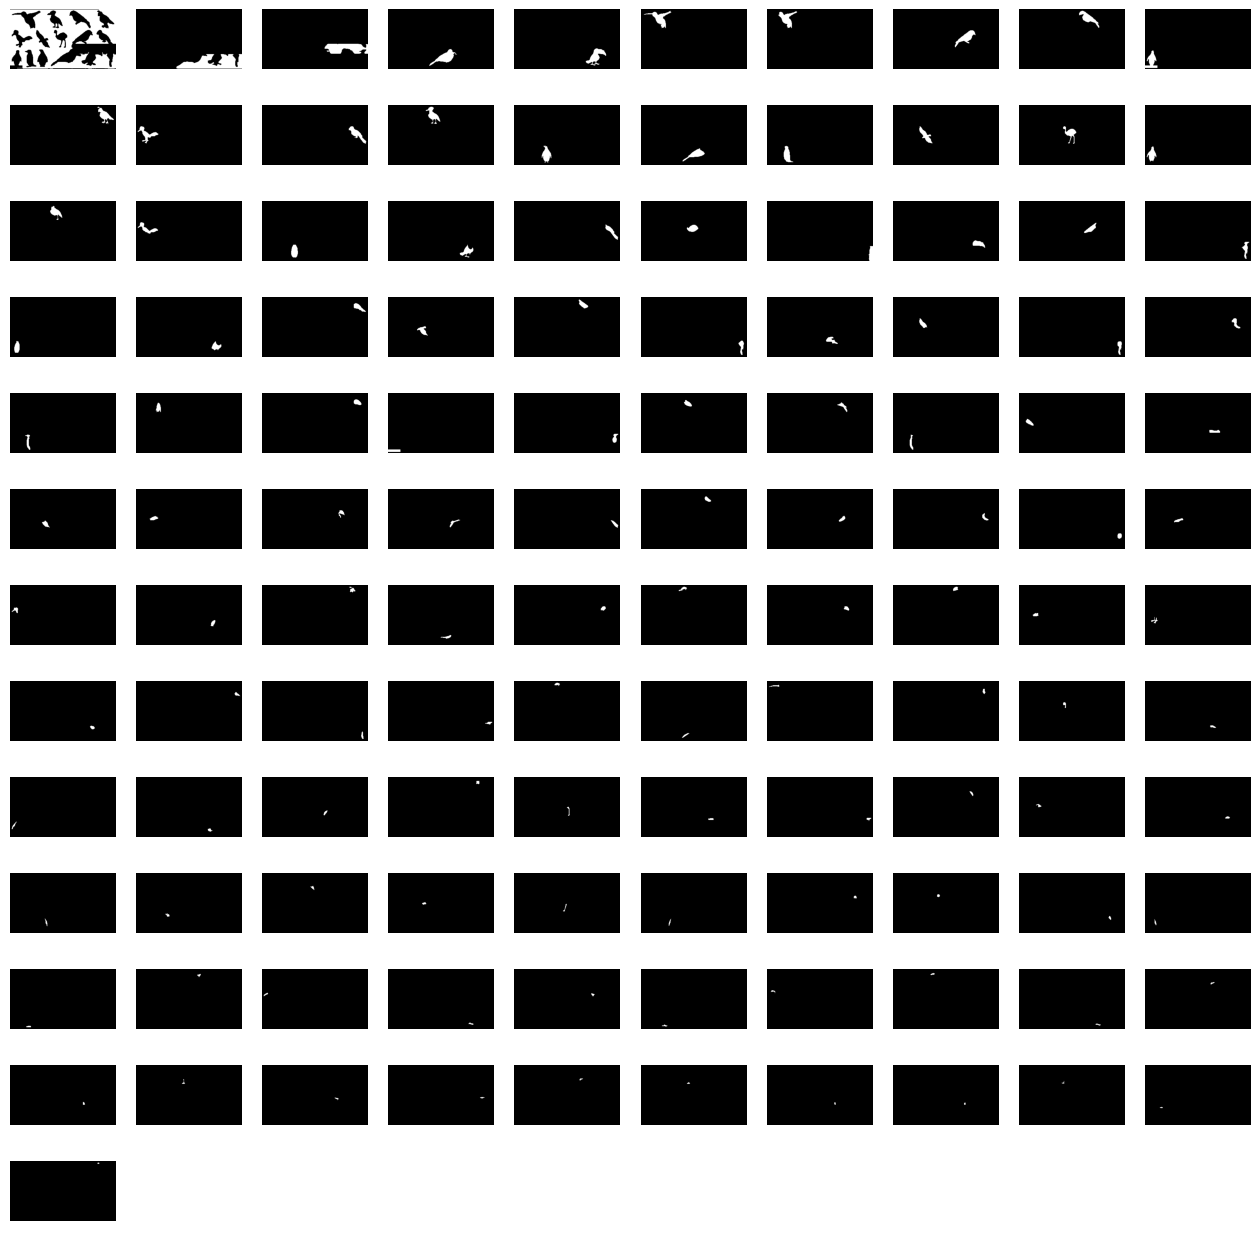

In [11]:
import math

# Number of images
num_images = len(sam_result)

# Calculate the number of rows and columns
rows = math.ceil(num_images / 10)  # Ensure enough rows to fit all images
cols = min(10, num_images)  # Maximum 10 columns, adjust if fewer images


masks = [
    mask['segmentation']
    for mask
    in sorted(sam_result, key=lambda x: x['area'], reverse=True)
]

sv.plot_images_grid(
    images=masks,
    grid_size=(rows, cols),
    size=(16, 16)
)

In [13]:
import tensorflow as tf

# Load a Keras model (adjust path to your model)
model = tf.keras.models.load_model("/Users/anshmadan/Coding/IML Final Project/my_custom_model.h5")

# Assume you have a list or dictionary that maps class indices to labels
class_names = ['Coppersmith-Barbet', 'Cattle-Egret', 'White-Breasted-Waterhen', 'Asian-Green-Bee-Eater', 'Common-Myna', 'Hoopoe', 'Gray-Wagtail', 'Jungle-Babbler', 'White-Wagtail', 'Common-Tailorbird', 'Common-Rosefinch', 'Rufous-Treepie', 'Ruddy-Shelduck', 'Sarus-Crane', 'Red-Wattled-Lapwing', 'Common-Kingfisher', 'House-Crow', 'White-Breasted-Kingfisher', 'Forest-Wagtail', 'Northern-Lapwing', 'Indian-Peacock', 'Indian-Pitta', 'Indian-Grey-Hornbill', 'Brown-Headed-Barbet', 'Indian-Roller']



2024-12-07 13:47:04.404090: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2024-12-07 13:47:04.404124: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-12-07 13:47:04.404129: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-12-07 13:47:04.404303: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-12-07 13:47:04.404328: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [14]:
import numpy as np

# Example preprocessing for an RGB image
# This should be adapted to your model's requirements.
def preprocess_image(image_rgb, target_size=(224, 224)):
    # Convert image to float32 and scale
    image = tf.image.convert_image_dtype(image_rgb, tf.float32)
    # Resize to match the classifier input size
    image = tf.image.resize(image, target_size)
    # Expand dimensions to create batch of size 1
    image = tf.expand_dims(image, axis=0)  # shape: (1, height, width, 3)
    return image


In [15]:
# Convert the original image to RGB if currently in BGR
image_rgb_full = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

labeled_boxes = []
for (x_min, y_min, x_max, y_max) in final_boxes:
    # Crop the image
    cropped_image = image_rgb_full[y_min:y_max+1, x_min:x_max+1]

    # Preprocess for classifier
    input_tensor = preprocess_image(cropped_image)  # shape: (1, 224, 224, 3) for example

    # Run prediction
    predictions = model.predict(input_tensor)  # shape: (1, num_classes)
    predicted_class_idx = np.argmax(predictions, axis=1)[0]
    label = class_names[predicted_class_idx]

    # Store or directly annotate
    labeled_boxes.append((x_min, y_min, x_max, y_max, label))


2024-12-07 13:47:08.745319: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 650ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


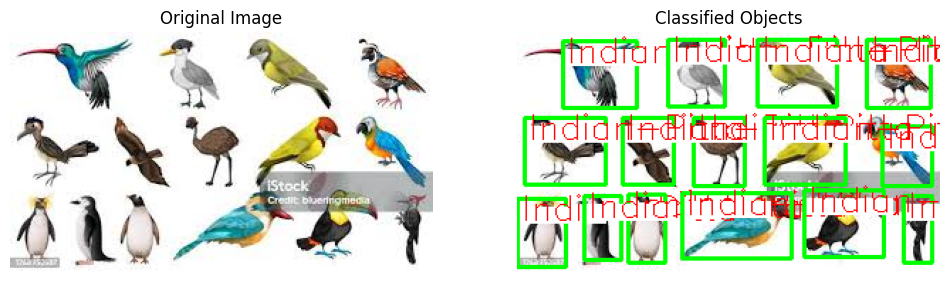

In [16]:
import cv2
import supervision as sv

# Assume you have:
# image_bgr: The original BGR image
# labeled_boxes: A list of tuples (x_min, y_min, x_max, y_max, label)
#                where (x_min, y_min) is the top-left corner of the box
#                and (x_max, y_max) is the bottom-right corner, and label is a string.

output_image = image_bgr.copy()

for (x_min, y_min, x_max, y_max, label) in labeled_boxes:
    # Draw bounding box in green
    cv2.rectangle(output_image, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
    
    # Position the text inside the bounding box slightly from the top-left corner
    text_x = x_min + 3
    text_y = y_min + 15  # This positions the text a bit below the top line of the bounding box
    
    # Get the size of the text to create a background rectangle
    text_size = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.3, 1)[0]
    
    # Draw a white rectangle behind the text to improve readability
    cv2.rectangle(
        output_image, 
        (text_x - 1, text_y - text_size[1] - 2), 
        (text_x + text_size[0] + 1, text_y + 2), 
        (255, 255, 255), 
        -1
    )
    
    # Put the red text on top of the white rectangle
    cv2.putText(
        output_image,
        label,
        (text_x, text_y),
        cv2.FONT_HERSHEY_SIMPLEX,
        0.8,               
        (0, 0, 255),         
        1
    )

images = [image_bgr, output_image]
titles = ["Original Image", "Classified Objects"]
sv.plot_images_grid(images=images, grid_size=(1, 2), titles=titles)


In [101]:
print(class_names[predicted_class_idx])

Common-Tailorbird
